In [1]:
import wget
import pandas as pd
import numpy as np 
import os
from numpy import trapz
from scipy.fft import  rfft, fftfreq
import umap
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import plotly.express as px
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN

In [2]:
from preprocess_data import *
from utils import *

## Data Preprocessing

In [3]:
a = preprocess_data()

  0%|          | 0/1349 [00:00<?, ?it/s]

  0%|          | 0/1349 [00:00<?, ?it/s]

  0%|          | 0/1349 [00:00<?, ?it/s]

In [5]:
#example 
df = pd.read_feather('../data/raw_data/GRB080903.fth')
df[df.center != 0]

center  15_25_keV  25_50_keV  50_100_keV  100_350_keV  15_350_keV
0    -10.536  -0.016749   0.040253    0.012057    -0.003267    0.032294
1    -10.472   0.023083   0.001653    0.008478     0.006373    0.039586
2    -10.408   0.013101   0.030002    0.021580    -0.013944    0.050738
3    -10.344   0.001536   0.011091   -0.014225     0.023651    0.022053
4    -10.280   0.013981   0.013753    0.021683     0.017974    0.067391
...      ...        ...        ...         ...          ...         ...
1223  67.736   0.010378   0.021187    0.004787    -0.004399    0.031953
1224  67.800  -0.005639  -0.010812   -0.011736    -0.012644   -0.040831
1225  67.864   0.005225   0.021898   -0.011956    -0.009490    0.005677
1226  67.928   0.031186  -0.006138    0.049890     0.000893    0.075831
1227  67.992   0.035292   0.011473   -0.001383     0.047626    0.093008

[1228 rows x 6 columns]

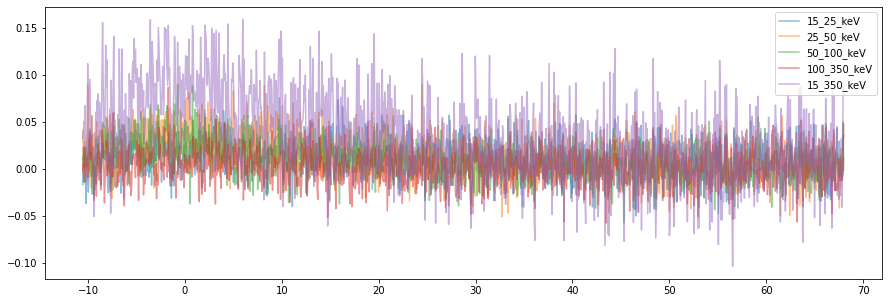

In [7]:
plt.figure(figsize = (15,5))
for i in df[df.center != 0].columns[1:]:
    plt.plot(df[df.center != 0].center, df[df.center != 0][i], label = i, alpha=0.5)
plt.legend()
plt.show()

In [ ]:
burst_names = [i for i in os.listdir('../data/raw_data') if 'fth' in i]

In [11]:
data = []

for name in tqdm(burst_names):
    df = pd.read_feather(f'../data/raw_data/{name}')


    y = df['15_350_keV']
    area = trapz(y)
    y3 = y/area

    y = list(y3)

    data.append(y)

# discrete fourier transform 
data = pd.DataFrame(data)
data.head()

  0%|          | 0/1349 [00:00<?, ?it/s]

0         1         2         3         4         5         6      \
0  0.007503  0.010015  0.010986  0.009562  0.006206  0.011565  0.010189   
1  0.004064  0.004700 -0.001783  0.006729  0.006819  0.007735  0.005359   
2  0.015112  0.020660  0.014745  0.031673  0.029807  0.025416  0.021048   
3  0.000142  0.000277 -0.000076  0.000288 -0.000010  0.000061  0.000127   
4  0.000431  0.000405  0.000806  0.000002  0.000299  0.000284  0.000187   

      7         8         9      ...  15298  15299  15300  15301  15302  \
0  0.014302  0.009023  0.011970  ...    0.0    0.0    0.0    0.0    0.0   
1  0.006582  0.005350  0.005619  ...    0.0    0.0    0.0    0.0    0.0   
2  0.028070  0.022229  0.021666  ...    0.0    0.0    0.0    0.0    0.0   
3  0.000202  0.000193 -0.000091  ...    0.0    0.0    0.0    0.0    0.0   
4  0.000166  0.000466  0.000377  ...    0.0    0.0    0.0    0.0    0.0   

   15303  15304  15305  15306  15307  
0    0.0    0.0    0.0    0.0    0.0  
1    0.0    0.0    0.0    0.0    0.0  
2    0.0    0.0    0.0    0.0    0.0  
3    0.0    0.0    0.0    0.0    0.0  
4    0.0    0.0    0.0    0.0    0.0  

[5 rows x 15308 columns]

In [13]:
data.columns = [str(x) for x in data.columns]
data.to_feather('burst_data_all.fth')

## 2d t-SNE 

In [7]:
t90_duration = pd.read_csv('t90_duration.csv')

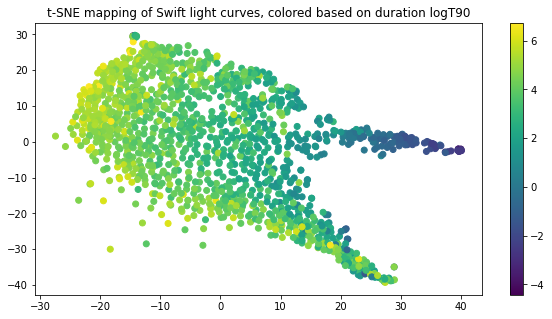

In [34]:
X = fit_tsne(a, 30, 2)
plot_2d_tsne(X)

In [40]:
#plot_2d_plotly(X)

In [16]:
#X[['name', 'x', 'y',  'T90']].to_csv('GRB_tsne.csv', index = False)

perplexity: 10


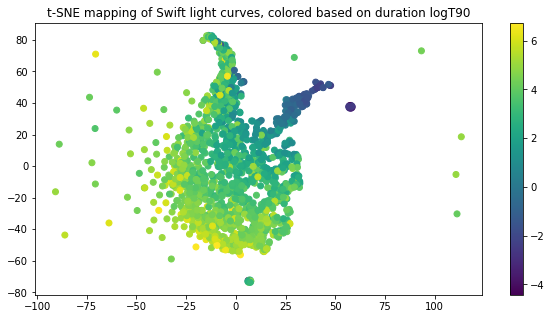

perplexity: 20


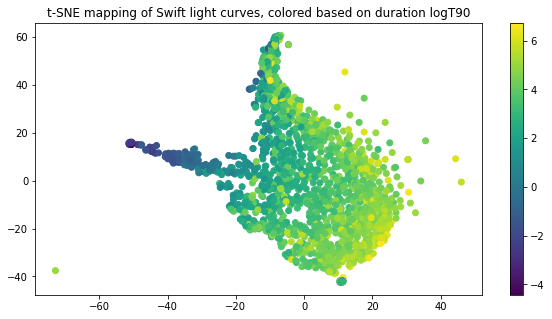

perplexity: 30


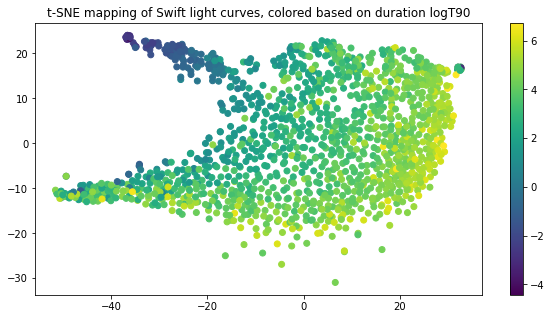

perplexity: 40


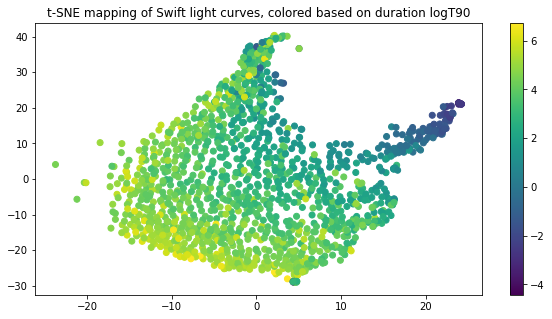

perplexity: 50


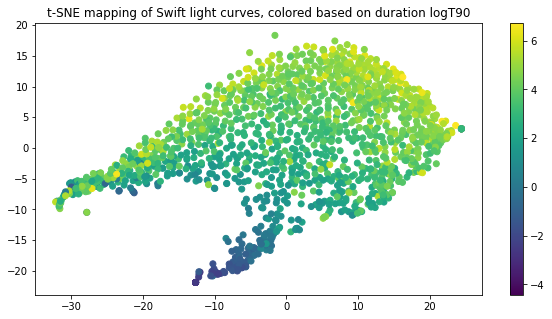

In [90]:
for j in [10,20,30,40,50,100]:
    print(f'perplexity: {j}')
    X = fit_tsne(a, j, 2)
    plot_2d_tsne(X)

## 3d t-SNE

In [4]:
X = fit_tsne(a, 30, 3)
plot_3d_plotly(X[(X.x != 636.3136) & (X.x != -41.994125)])

## Umap - 2d

In [63]:
for n in [7, 15, 30, 45, 60]:
    print(f'neighbours: {n}')
    X = fit_umap(a, n, 2)
    plot_2d_plotly(X)

neighbours: 7


neighbours: 15


neighbours: 30


neighbours: 45


neighbours: 60


## 3d UMAP

In [64]:
X = fit_umap(a, 30, 3)
plot_3d_plotly(X)

## Clustering based on preprocessed data


### KMeans
Проводим предобработку данных. После применения DFT применяем KMeans.

In [4]:
kmeans_kwargs = {
    "init": "k-means++",
    "n_init": 10,
    "max_iter": 1000,
    "random_state": 42,
}


In [98]:
sse = []
for k in tqdm(range(1, 11)):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(a)
    sse.append(kmeans.inertia_)

  0%|          | 0/10 [00:00<?, ?it/s]

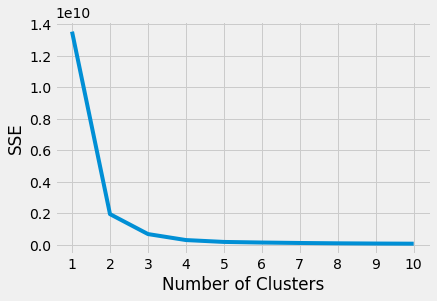

In [99]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

n_clusters: 2


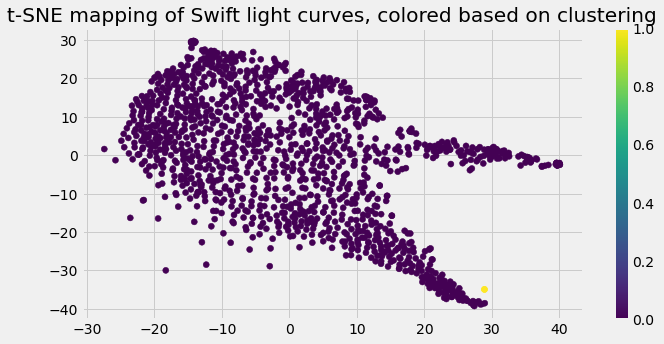

n_clusters: 3


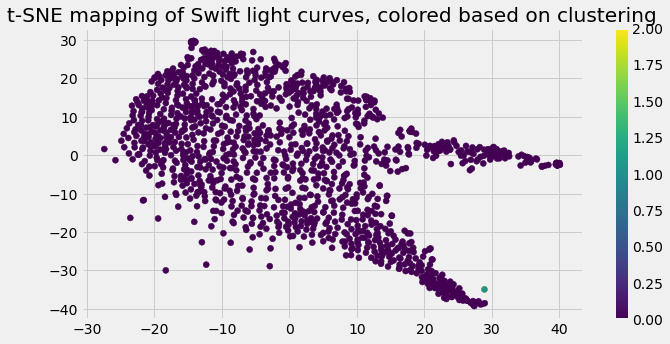

In [103]:
for k in [2,3]:
    print(f'n_clusters: {k}')
        
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(a)
    
    X = fit_tsne(a, 30, 2)
    
    X['cluster'] = kmeans.labels_
    
    plot_clusters(X)


Над данными после DFT Kmeans не работает. Попробуем сжать размерность с помощью pca, потом применить Kmeans и потом уже на двумерной плоскости, полученной с помощью kmeans посмотрим на результат.

n_clusters: 2


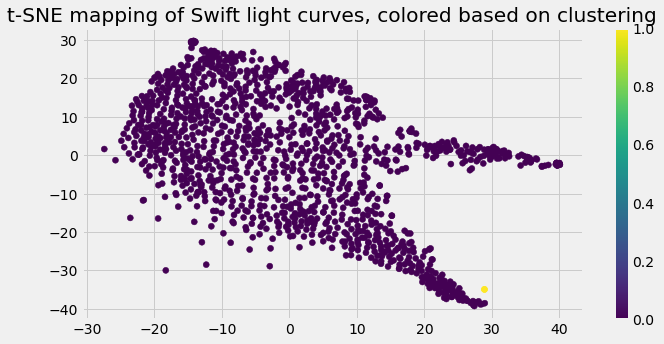

n_clusters: 3


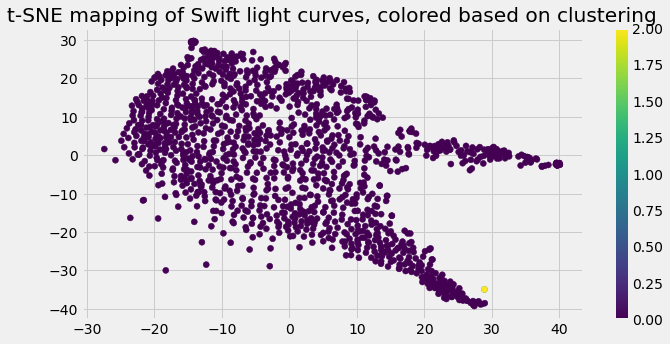

In [106]:
for k in [2,3]:
    print(f'n_clusters: {k}')
    
    pca = PCA(n_components = 250)
    X = pca.fit_transform(a)
    X = pd.DataFrame(X)
    
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(X)
    
    X = fit_tsne(a, 30, 2)
    
    X['cluster'] = kmeans.labels_
    
    plot_clusters(X)
    

n_clusters: 2


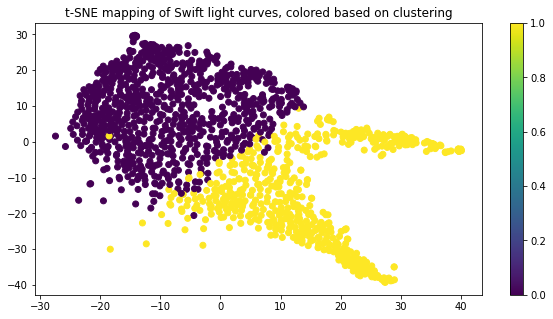

n_clusters: 3


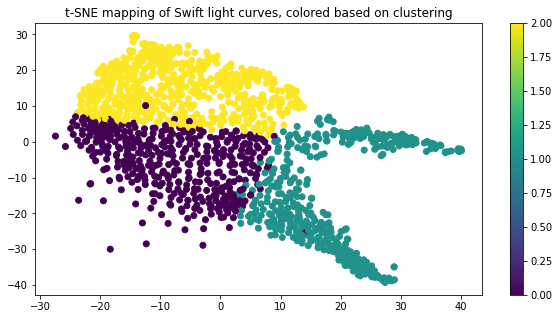

n_clusters: 4


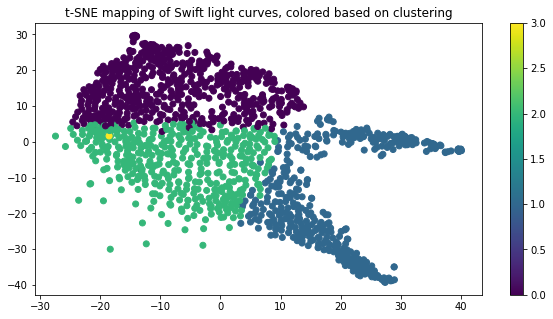

In [7]:
for k in [2,3,4]:
    print(f'n_clusters: {k}')
    
    pca = TSNE(n_components = 3)
    X = pca.fit_transform(a)
    X = pd.DataFrame(X)
    
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(X)
    
    X = fit_tsne(a, 30, 2)
    
    X['cluster'] = kmeans.labels_
    
    plot_clusters(X)


### DBSCAN

eps: 0.1


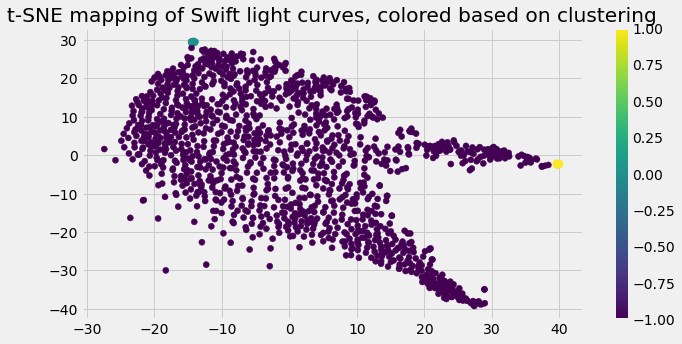

eps: 0.3


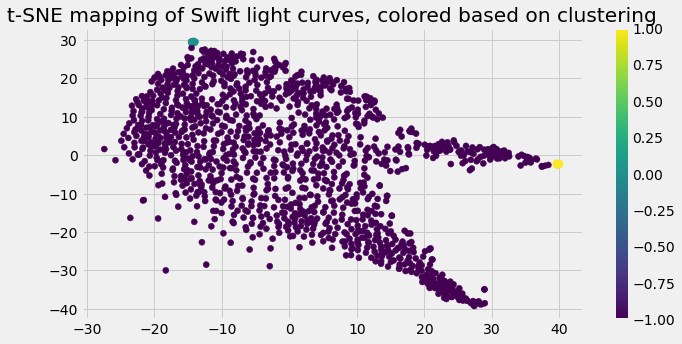

eps: 0.5


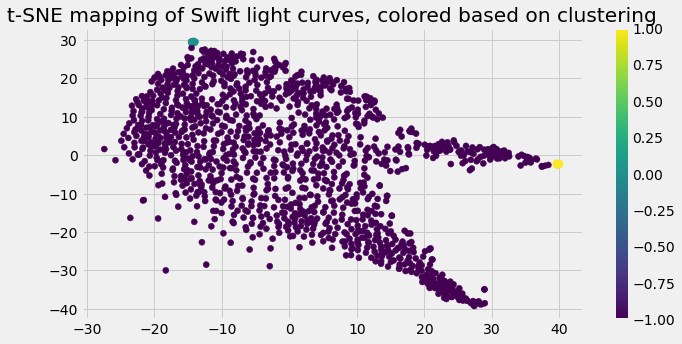

eps: 1


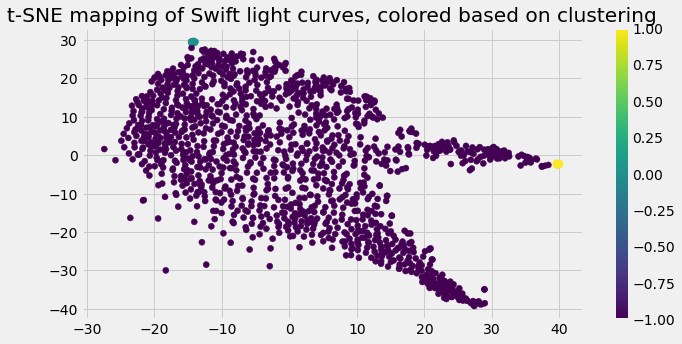

eps: 3


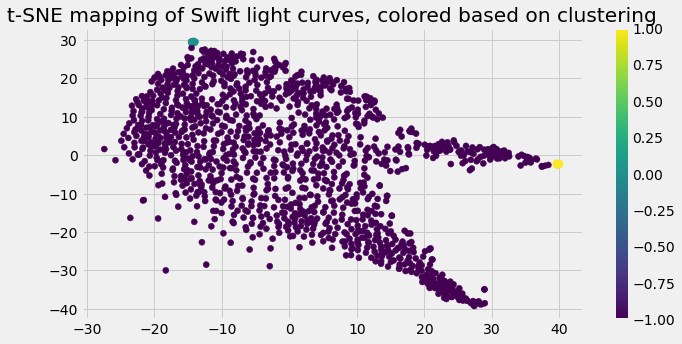

In [109]:
for k in [0.1, 0.3, 0.5, 1, 3]:
    print(f'eps: {k}')
    dbscan = DBSCAN(eps=k)
    dbscan.fit(a)
    X = fit_tsne(a, 30, 2)
    X['cluster'] = dbscan.labels_
    plot_clusters(X)
